In [1]:
!jupyter nbconvert --to script lstm_new.ipynb
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import copy
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import random
import sys
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from geopy import distance

[NbConvertApp] Converting notebook lstm_new.ipynb to script
[NbConvertApp] Writing 16209 bytes to lstm_new.py


In [2]:
#LOCATIONS = [int(sys.argv[1])]
LOCATIONS = [40134005, 40137020, 40133003]
STOP_DATE = '2019-12-29'
PHYSICAL_VARIABLES = ['O3', 'TEMP2', 'RGRND', 'PBL2', 'WDIR10', 'WSPD10', 'NOX', 'NOY', 'TIMEOFDAY']

LAYERS = 5
EPOCHS = 100
#UNITS = int(sys.argv[2])
UNITS = 100
DROPOUT = 0.25
PATIENCE = 5.0
LSTM_TYPES = ['pre', 'mid', 'end']
TYPE_OFFSETS = {'pre': 0, 'mid': int(24/2), 'end': 23}

TEST_DAY = '2019-07-29'
#TEST_LOCATION = int(sys.argv[1])
TEST_LOCATION = LOCATIONS[-1]
TEST_STAMP = pd.Timestamp(TEST_DAY+' 13:00:00')

EXPERIMENT_NAME = "month+layers comparison"
CURRENT_EXPERIMENT = str(LAYERS)+" layers"
#OUTPUT_DIR = 'plots/2019-01-24/'+EXPERIMENT_NAME+"/2 months/"+CURRENT_EXPERIMENT+'/'+str(TEST_LOCATION)
OUTPUT_DIR = 'plots/2019-02-01/multi/8 km'

In [3]:
airnow_data, forecast_data = pickle.load(open("/xace/d1/hamer/pickle_files/data.p", "rb"))

airnow_data = airnow_data[LOCATIONS]
forecast_data = forecast_data[np.in1d(forecast_data.index.get_level_values(1), LOCATIONS)].loc[:STOP_DATE]

# We need one scaler for each variable, so we use a dictionary to store them all
scaler = {}

# We make a copy of the forecast data so we do not accidentally modify the original
forecast_data_scaled = copy.copy(forecast_data)

for variable in tqdm(PHYSICAL_VARIABLES, desc='Normalizing Data'):
    
    # The forecast data is sliced to get all values of a specific physical variable for the locations
    # currently being used.

    #current_forecast = forecast_data.loc[(slice(None), slice(*LOCATIONS)),variable]
    current_forecast = forecast_data.loc[(slice(None), slice(None)),variable]
    
    current_variable_data = np.array(current_forecast)

    # Ozone needs to be handled differently, since we need to include the AirNow observations
    # when generating the scaler (because AirNow observations are of ozone concentration)
    if(variable=='O3'):
        
        # The AirNow data contains some invalid values which need to not be considered
        # when generating the scaler, so we ensure those values do not get included along
        # with the rest of the data
        current_airnow =  np.array(airnow_data[LOCATIONS])
        current_airnow = current_airnow[current_airnow != -999000.0]
        
        current_variable_data = np.concatenate([current_variable_data,current_airnow.flatten()])
        
    # The scaler is then generated using all values of the physical variable
    scaler[variable] = StandardScaler().fit(np.array(current_variable_data).reshape(-1,1))
    
    # The scaled data is inserted into the scaled forecast dataframe.
    scaled_data = scaler[variable].transform(np.array(current_forecast).reshape(-1,1))
    #forecast_data_scaled.loc[(slice(None), slice(*LOCATIONS)),variable] = scaled_data
    forecast_data_scaled.loc[(slice(None), slice(None)),variable] = scaled_data

Normalizing Data:   0%|          | 0/9 [00:00<?, ?it/s]

In [4]:
ALL_FORECAST_DAYS = np.unique(forecast_data_scaled.index.get_level_values('forecast_day'))

print("Generating Timesteps")

# Create a list to hold each location's forecast days as dataframes
locations = []

for forecast_location in tqdm(LOCATIONS, desc="Locations"): #[:limiter]
    
    # Create a list to hold each forecast day's timesteps
    days = []
    
    for forecast_day in ALL_FORECAST_DAYS: # [:limiter]
        
        # Given a particular forecast day and a partiular location, we generate all 24 hour timesteps for that day
        # as invidivual dataframes and put them together into a list.
        #timesteps = [forecast_data_scaled.loc[forecast_day].loc[forecast_location].iloc[i:i+24] for i in range(25-1)]
        data = forecast_data_scaled.loc[forecast_day].loc[forecast_location]
        timesteps = [data.iloc[i:i+24] for i in range(25-1)]

        # We combine these dataframes together into a single large dataframe using a new index (timestep) to reference each one
        current_day = pd.concat(timesteps, keys=range(25-1), axis=0, names=['timestep', *timesteps[0].index.names])
        
        # This large dataframe is in turn added to the list of combined timestep dataframes for each forecast day for the current location
        days.append(current_day)
    
    # The dataframes for each forecast day are themselves combined together to create a single very large dataframe for the current location
    current_location = pd.concat(days, keys=ALL_FORECAST_DAYS, axis=0, names=['forecast_day', *days[0].index.names])
    locations.append(current_location)
    
# The same process as above is repeated to combine the very large dataframes from each location together
# into a single massive one for each lstm type
all_training_data = pd.concat(locations, keys=LOCATIONS, axis=0, names=['stationid', *locations[0].index.names])

Generating Timesteps


Locations:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
all_training_data

var                                                       NOX       NOY  \
stationid forecast_day timestep date_time                                 
40134005  2019-07-01   0        2019-07-01 13:00:00  1.237264  1.260108   
                                2019-07-01 14:00:00  1.837128  1.826388   
                                2019-07-01 15:00:00  1.428612  1.472843   
                                2019-07-01 16:00:00  0.995348  1.188952   
                                2019-07-01 17:00:00  0.068170  0.347514   
...                                                       ...       ...   
40133003  2019-12-29   23       2019-12-31 07:00:00 -0.698251 -0.804488   
                                2019-12-31 08:00:00 -0.728429 -0.832841   
                                2019-12-31 09:00:00 -0.739249 -0.843980   
                                2019-12-31 10:00:00 -0.749861 -0.856232   
                                2019-12-31 11:00:00 -0.762233 -0.869661   

var                                                        O3      PBL2  \
stationid forecast_day timestep date_time                                 
40134005  2019-07-01   0        2019-07-01 13:00:00 -1.373449 -0.605074   
                                2019-07-01 14:00:00 -1.244199 -0.605840   
                                2019-07-01 15:00:00 -0.446774 -0.608231   
                                2019-07-01 16:00:00  0.627442 -0.558482   
                                2019-07-01 17:00:00  1.748885 -0.119570   
...                                                       ...       ...   
40133003  2019-12-29   23       2019-12-31 07:00:00 -0.265796 -0.624378   
                                2019-12-31 08:00:00 -0.257899 -0.626158   
                                2019-12-31 09:00:00 -0.297694 -0.625460   
                                2019-12-31 10:00:00 -0.342705 -0.622377   
                                2019-12-31 11:00:00 -0.374750 -0.620908   

var                                                     RGRND     TEMP2  \
stationid forecast_day timestep date_time                                 
40134005  2019-07-01   0        2019-07-01 13:00:00 -0.725318  0.636415   
                                2019-07-01 14:00:00 -0.497314  0.479648   
                                2019-07-01 15:00:00  0.120145  0.546212   
                                2019-07-01 16:00:00  0.796732  0.721603   
                                2019-07-01 17:00:00  1.415377  0.920073   
...                                                       ...       ...   
40133003  2019-12-29   23       2019-12-31 07:00:00 -0.725318 -1.744615   
                                2019-12-31 08:00:00 -0.725318 -1.741525   
                                2019-12-31 09:00:00 -0.725318 -1.745189   
                                2019-12-31 10:00:00 -0.725318 -1.749291   
                                2019-12-31 11:00:00 -0.725318 -1.757031   

var                                                  TIMEOFDAY    WDIR10  \
stationid forecast_day timestep date_time                                  
40134005  2019-07-01   0        2019-07-01 13:00:00   0.216695 -0.367063   
                                2019-07-01 14:00:00   0.361158 -0.906444   
                                2019-07-01 15:00:00   0.505621 -0.725034   
                                2019-07-01 16:00:00   0.650084 -0.247791   
                                2019-07-01 17:00:00   0.794547  0.091195   
...                                                        ...       ...   
40133003  2019-12-29   23       2019-12-31 07:00:00  -0.650084 -1.106652   
                                2019-12-31 08:00:00  -0.505621 -1.087644   
                                2019-12-31 09:00:00  -0.361158 -1.075432   
                                2019-12-31 10:00:00  -0.216695 -1.120006   
                                2019-12-31 11:00:00  -0.072232 -1.114262   

var                                                    WSPD10  
stationid forecast_

Extract the testing data from the forecast data

In [6]:
test_data = copy.copy(all_training_data.xs(TEST_LOCATION, level="stationid", axis=0).loc[TEST_DAY])
test_data

var                                NOX       NOY        O3      PBL2  \
timestep date_time                                                     
0        2019-07-29 13:00:00  0.425909  0.373936 -0.650095 -0.607409   
         2019-07-29 14:00:00  1.210441  1.148130 -1.079263 -0.607409   
         2019-07-29 15:00:00  1.018098  0.971496 -0.636424 -0.619801   
         2019-07-29 16:00:00  1.049037  1.047158 -0.233114 -0.441402   
         2019-07-29 17:00:00  0.820135  0.916829  0.426529 -0.246770   
...                                ...       ...       ...       ...   
23       2019-07-31 07:00:00 -0.597636 -0.545470  0.698685 -0.370755   
         2019-07-31 08:00:00 -0.715186 -0.680571  0.723059 -0.374985   
         2019-07-31 09:00:00 -0.770242 -0.751274  0.695435 -0.208255   
         2019-07-31 10:00:00 -0.819106 -0.821948  0.645778 -0.275514   
         2019-07-31 11:00:00 -0.840161 -0.860567  0.627060 -0.268403   

var                              RGRND     TEMP2  TIMEOFDAY    WDIR10  \
timestep date_time                                                      
0        2019-07-29 13:00:00 -0.725318  0.780538   0.216695  1.916625   
         2019-07-29 14:00:00 -0.620694  0.704873   0.361158 -0.511394   
         2019-07-29 15:00:00 -0.273010  0.759647   0.505621 -0.573400   
         2019-07-29 16:00:00 -0.013661  0.788307   0.650084  0.031707   
         2019-07-29 17:00:00  0.490833  0.868681   0.794547  0.341720   
...                                ...       ...        ...       ...   
23       2019-07-31 07:00:00 -0.725318  0.037972  -0.650084  0.914996   
         2019-07-31 08:00:00 -0.725318  0.026800  -0.505621  1.076630   
         2019-07-31 09:00:00 -0.725318  0.021963  -0.361158 -0.279652   
         2019-07-31 10:00:00 -0.725318  0.035364  -0.216695 -0.452723   
         2019-07-31 11:00:00 -0.725318  0.051064  -0.072232 -0.412240   

var                             WSPD10  
timestep date_time                      
0        2019-07-29 13:00:00 -1.762415  
         2019-07-29 14:00:00 -1.050184  
         2019-07-29 15:00:00 -1.079288  
         2019-07-29 16:00:00 -0.938584  
         2019-07-29 17:00:00 -0.538425  
...                                ...  
23       2019-07-31 07:00:00 -0.978751  
         2019-07-31 08:00:00 -1.533899  
         2019-07-31 09:00:00 -1.332326  
         2019-07-31 10:00:00 -1.075429  
         2019-07-31 11:00:00 -0.733912  

[576 rows x 9 columns]

Mark the forecast day we extracted as invalid so it will be removed later. We also remove the previous day since its forecast data extends into the testing day.

In [7]:
all_training_data.loc[TEST_LOCATION,TEST_DAY] = -999000
prev_day = str(pd.to_datetime(TEST_DAY)-pd.Timedelta(1, 'd'))[:10]
all_training_data.loc[TEST_LOCATION,TEST_DAY] = -999000

Test data is generated by matching up each timestep in the testing set's forecast data to the corresponding airnow observation

In [8]:
# lstm_type, location, forecast_day, timestep_number, time
X_test = {}
Y_test = {}
# lstm_type, location, forecast_day, timestep_number

# We create a dictionary entry for each LSTM type
for lstm_type in LSTM_TYPES:
    
    # The test data set is reshaped into an array where each entry is a 24 hour timestep
    X_test[lstm_type] = np.array(test_data).reshape((-1,24,9))

    # In order to create the ground truth for the testing set, we need to know what time span we need to pull from.
    # Each 24 hour timestep has a ground truth airnow observation value associated with it (which is what the LSTM 
    # is trying to use that timestep to predict). This time of this airnow observation is either at the beginning
    # of the 24 hour block (for the "pre" LSTM), in the middle of the block (for the "mid" LSTM), or at the end
    # (for the "end" LSTM). For an entire 48 hour forecast day (which has 24 timesteps in it), this means that we
    # are interested in the observations of the first 24 hours of the day (for 'pre'), the middle 24 (for 'mid'),
    # and the final 24 (for 'end'). We can easily generate the specific list of times we are interested by staring
    # at 13:00 GMT of the forecast day, adding an offset to it depending on the lstm type, then getting all observations
    # for the next 24 hours onwards.
    start_time = pd.to_datetime(TEST_DAY+' 13:00:00')+pd.Timedelta(TYPE_OFFSETS[lstm_type], 'h')
    times = pd.date_range(start_time, periods=24, freq="H")
    
    Y_test[lstm_type] = np.array(airnow_data.loc[times][TEST_LOCATION])

Training and validation data is generated by matching up each timestep in the main data set's forecast data to the corresponding airnow observation

In [9]:

X = {}
Y = {}

# We create a dictionary entry for each LSTM type
for lstm_type in LSTM_TYPES:
    
    print("Generating training data for '"+lstm_type+"' LSTM")
    
    X[lstm_type] = np.array(all_training_data).reshape((-1,24,9))

    current_data_X = []
    current_data_Y = []
    
    for current_ids in tqdm(np.unique(all_training_data.index.get_level_values('stationid'))):
        for current_day in np.unique(all_training_data.index.get_level_values('forecast_day')):
    
            # The test data set is reshaped into an array where ecah entry is a 24 hour timestep

            # In order to create the ground truth for the testing set, we need to know what time span we need to pull from.
            # Each 24 hour timestep has a ground truth airnow observation value associated with it (which is what the LSTM 
            # is trying to use that timestep to predict). This time of this airnow observation is either at the beginning
            # of the 24 hour block (for the "pre" LSTM), in the middle of the block (for the "mid" LSTM), or at the end
            # (for the "end" LSTM). For an entire 48 hour forecast day (which has 24 timesteps in it), this means that we
            # are interested in the observations of the first 24 hours of the day (for 'pre'), the middle 24 (for 'mid'),
            # and the final 24 (for 'end'). We can easily generate the specific list of times we are interested by staring
            # at 13:00 GMT of the forecast day, adding an offset to it depending on the lstm type, then getting all observations
            # for the next 24 hours onwards.
            start_time = pd.to_datetime(current_day+' 13:00:00')+pd.Timedelta(TYPE_OFFSETS[lstm_type], 'h')
            times = pd.date_range(start_time, periods=24, freq="H")

            current_data_Y.append(np.array(airnow_data.loc[times][current_ids]))
            
    Y[lstm_type] = np.concatenate(current_data_Y)

Generating training data for 'pre' LSTM


  0%|          | 0/3 [00:00<?, ?it/s]

Generating training data for 'mid' LSTM


  0%|          | 0/3 [00:00<?, ?it/s]

Generating training data for 'end' LSTM


  0%|          | 0/3 [00:00<?, ?it/s]

Invalid values are removed from the training data

In [10]:
X_cleaned = {}
Y_cleaned = {}

for lstm_type in LSTM_TYPES:
    invalid_X = np.unique(np.where(X[lstm_type] <= -999000)[0])
    invalid_Y = np.where(Y[lstm_type] <= -999000)[0]

    invalid_data = np.concatenate([invalid_X, invalid_Y])
    #print(invalid_data)

    X_cleaned[lstm_type] = np.delete(X[lstm_type], invalid_data, axis=0)
    Y_cleaned[lstm_type] = np.delete(Y[lstm_type], invalid_data)
    
    # Here we finally normalize the ground truth observations (we held off on this since we did not want to
    # modify the special -999000 value that indicated invalid data, since we were using that in order to clean
    # the training and validation sets)
    Y_cleaned[lstm_type] = scaler['O3'].transform(Y_cleaned[lstm_type].reshape(-1,1)).reshape((-1,))

Non-testing data is shuffled

In [11]:
X_final = {}
Y_final = {}

for lstm_type in LSTM_TYPES:
    perm = np.random.default_rng().permutation(Y_cleaned[lstm_type].shape[0])
    X_final[lstm_type] = X_cleaned[lstm_type][perm]
    Y_final[lstm_type] = Y_cleaned[lstm_type][perm]

Data is separated into training and validation sets

In [12]:
X_train = {}
Y_train = {}

X_val = {}
Y_val = {}

for lstm_type in LSTM_TYPES:
    
    index = int(X_final[lstm_type].shape[0]*0.95)
    
    X_train[lstm_type] = X_final[lstm_type][:index]
    Y_train[lstm_type] = Y_final[lstm_type][:index]
    
    X_val[lstm_type] = X_final[lstm_type][index:]
    Y_val[lstm_type] = Y_final[lstm_type][index:]

In [13]:
# [samples, timesteps, features]
model = {}
history = {}
for lstm_type in LSTM_TYPES:
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=PATIENCE)
    model[lstm_type] = tf.keras.Sequential()
    
    if(LAYERS <= 1):
        model[lstm_type].add(
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(UNITS, input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2]),
                                     dropout=DROPOUT, stateful=False, return_sequences=False),
                input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2])))
    else:
        model[lstm_type].add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(UNITS, input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2]), dropout=DROPOUT, stateful=False, return_sequences=True), input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2])))
        for i in range(LAYERS-2):
            model[lstm_type].add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(UNITS, dropout=DROPOUT, stateful=False, return_sequences=True), input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2])))
        model[lstm_type].add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(UNITS, dropout=DROPOUT, stateful=False, return_sequences=False), input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2])))
    
    model[lstm_type].add(tf.keras.layers.Dense(1))
    model[lstm_type].compile(loss='mae', optimizer='adam')
    model[lstm_type].summary()
    #history[lstm_type] = model[lstm_type].fit(X_train[lstm_type], Y_train[lstm_type], epochs=EPOCHS, batch_size=32, validation_data=(X_val[lstm_type], Y_val[lstm_type]), verbose=1, shuffle=False, callbacks=[early_stopping, reduce_lr])
    #history[lstm_type] = model[lstm_type].fit(X_train[lstm_type], Y_train[lstm_type], epochs=EPOCHS, batch_size=32, validation_data=(X_val[lstm_type], Y_val[lstm_type]), verbose=1, shuffle=False, callbacks=[reduce_lr])
    history[lstm_type] = model[lstm_type].fit(X_train[lstm_type], Y_train[lstm_type], epochs=EPOCHS, batch_size=32, validation_data=(X_val[lstm_type], Y_val[lstm_type]), verbose=1, shuffle=False)
    #model[lstm_type].save(os.path.join(HP["model_dir"],lstm_type))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 24, 200)           88000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24, 200)           240800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24, 200)           240800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 24, 200)           240800    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 1,051,401
Trainable params: 1,051,401
Non-trainable params: 0
______________________________________________

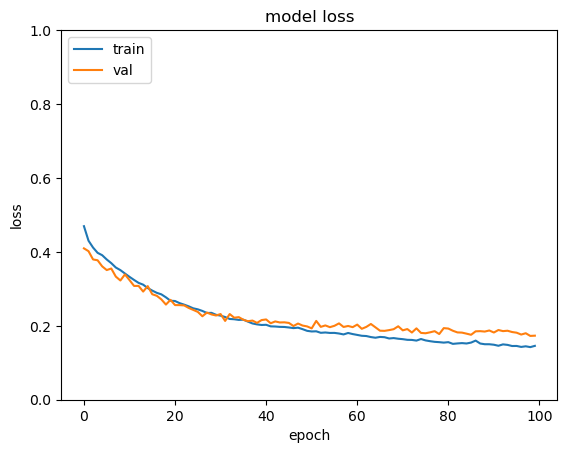

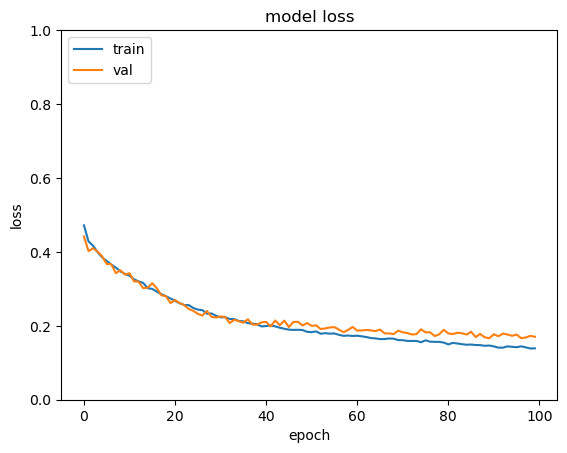

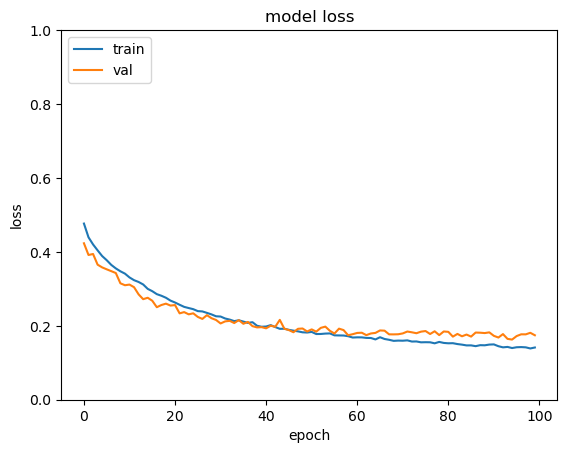

In [14]:
for lstm_type in LSTM_TYPES:
    plt.plot(history[lstm_type].history['loss'])
    plt.plot(history[lstm_type].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim([0,1])
    plt.legend(['train', 'val'], loc='upper left')
    if(not(os.path.exists(OUTPUT_DIR))):
        os.makedirs(OUTPUT_DIR)
    plt.savefig(OUTPUT_DIR+"/training.png", dpi=100)  
    plt.show()

In [15]:
model_output = {}

for lstm_type in LSTM_TYPES:
    predict = model[lstm_type].predict(X_test[lstm_type])
    model_output[lstm_type] = scaler['O3'].inverse_transform([predict.flatten()]).reshape(predict.shape)

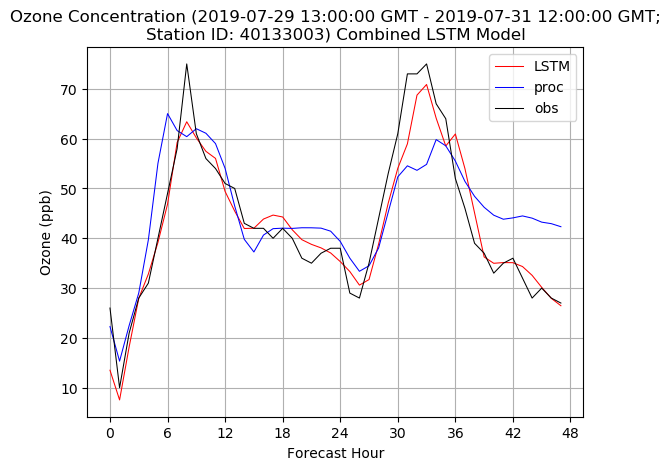

In [16]:
model_line_pre = model_output['pre'][:12]
model_line_mid = model_output['mid']
model_line_end = model_output['end'][-12:]

model_line = np.concatenate([model_line_pre,model_line_mid,model_line_end])

forecast_line = np.array(forecast_data.loc[TEST_DAY, TEST_LOCATION]['O3'])

airnow_line = np.array(airnow_data.loc[pd.date_range(TEST_STAMP, periods=48, freq='h')][TEST_LOCATION])
airnow_line[airnow_line<=-999000] = None

plt.plot(model_line, label='LSTM', color="red", linewidth=0.75)
plt.plot(forecast_line, label='proc', color="blue", linewidth=0.75)
plt.plot(airnow_line, label='obs', color="black", linewidth=0.75)

plt.xlabel("Forecast Hour")
plt.ylabel("Ozone (ppb)")
plt.xticks([0,6,12,18,24,30,36,42,48])
plt.grid()

plt.title("Ozone Concentration ("+str(TEST_STAMP)+" GMT - "+str(TEST_STAMP+pd.Timedelta(47,'h'))+" GMT;\nStation ID: "+str(TEST_LOCATION)+") Combined LSTM Model")
plt.legend()

if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/base.png", dpi=100)  

plt.show()
plt.clf()

In [17]:
model_cleaned = np.delete(model_line,np.argwhere(np.isnan(airnow_line)))
forecast_cleaned = np.delete(forecast_line,np.argwhere(np.isnan(airnow_line)))
airnow_cleaned = np.delete(airnow_line,np.argwhere(np.isnan(airnow_line)))
output = []
output.append("Forecast RMSE: "+str(mean_squared_error(forecast_cleaned, airnow_cleaned,squared=False)))
output.append("LSTM RMSE: "+str(mean_squared_error(model_cleaned, airnow_cleaned,squared=False)))
output.append("\nMaximum for first 15 hours:")
output.append("Forecast Max: "+str(max(forecast_cleaned[:16])))
output.append("LSTM Max: "+str(max(model_cleaned[:16])))
output.append("AirNow Max: "+str(max(airnow_cleaned[:16])))
output.append("\nMaximum for next 24 hours:")
output.append("Forecast Max: "+str(max(forecast_cleaned[16:40])))
output.append("LSTM Max: "+str(max(model_cleaned[16:40])))
output.append("AirNow Max: "+str(max(airnow_cleaned[16:40])))
with open(OUTPUT_DIR+"/out.txt", "w") as f:
    for string in output:
        print(string)
        f.write(string)
        f.write('\n')

Forecast RMSE: 9.205138150552884
LSTM RMSE: 4.669049908423362

Maximum for first 15 hours:
Forecast Max: 65.02945709228516
LSTM Max: 63.391544171921765
AirNow Max: 75.0

Maximum for next 24 hours:
Forecast Max: 59.81476593017578
LSTM Max: 70.8706443814255
AirNow Max: 75.0
